# Detailed Exploration of Universal Gate Set for Large Zeta

## Header

In [174]:
import numpy as np
import QDYN
from QDYN.shutil import mkdir
from QDYN.pulse import Pulse, pulse_tgrid
from QDYN.gate2q import Gate2Q
from QDYN.linalg import norm, vectorize
from os.path import join
from notebook_utils import (
    get_zeta_table, plot_zeta_data, filter_table, get_logical_energies_table,
    get_stage4_table, bare_decomposition, get_transition_table, J_target,
    get_w_d_from_config)
from mgplottools.io import writetotxt
from select_for_stage4 import GATE_RE, GATE_IM, GATE
from generate_zeta_universal import write_config
from analytical_pulses import AnalyticalPulse
from run_oct import propagate
from collections import OrderedDict
from zeta_systematic_variation import systematic_variation
import pandas as pd
import QDYNTransmonLib
from mgplottools.io import writetotxt

In [2]:
H_left = GATE['H_left']
def write_target_gate_dat(rf, gate):
    writetotxt(join(rf, 'target_gate.dat'), GATE_RE[gate], GATE_IM[gate])

In [3]:
def J_PE(U):
    if U is None:
        return None
    else:
        C = U.closest_unitary().concurrence()
        max_loss = np.max(1.0 - U.logical_pops())
        return J_target('PE', C, max_loss)

def F_avg_H_left(U):
    if U is None:
        return None
    else:
        return U.F_avg(H_left)

In [4]:
from multiprocessing import Process
import os
def system(cmd):
    p = Process(target=os.system, args=(cmd,))
    p.start()
    return p

In [5]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [6]:
get_zeta_table = QDYN.memoize.memoize(get_zeta_table)
get_zeta_table.load('zeta_table.cache')

In [7]:
zeta_table = get_zeta_table('./runs_050_RWA', T=50)

In [8]:
w_max = 1.0 # minimum frequency in the rotating frame to be resolved. (for calculation of nt)

In [9]:
n_qubit = 5; n_cavity = 6

In [134]:
def mark_freqs(rf, transition_table):
    """Return the frequencies that should be highlighted in the spectrum plot"""
    w_d = get_w_d_from_config(join(rf, 'config'))
    w1_dressed0 = transition_table['E10 - E00 [MHz]'][0] / 1000.0 # GHz
    w1_dressed1 = transition_table['E11 - E01 [MHz]'][0] / 1000.0 # GHz
    w2_dressed0 = transition_table['E01 - E00 [MHz]'][0] / 1000.0 # GHz
    w2_dressed1 = transition_table['E11 - E10 [MHz]'][0] / 1000.0 # GHz
    wc = 6.35 # GHZ
    w2 = 6.39 # GHz
    w1 = 6.00 # GHz
    return [(w1_dressed0-w_d, {'color':'black', 'ls':'--'}),
            (w1_dressed1-w_d, {'color':'black', 'ls':'--'}),
            (w2_dressed0-w_d, {'color':'gray', 'ls':'--'}),
            (w2_dressed1-w_d, {'color':'gray', 'ls':'--'}),
            (wc-wd,           {'color':'gray', 'ls':'dotted'}),
            (w2-wd,           {'color':'gray', 'ls':'-.'}),
            (w1-wd,           {'color':'black', 'ls':'-.'})]

## Analysis

### Properties of the Hamiltonian

In [11]:
wc = 6.35 # GHZ
w2 = 6.39 # GHz
w1 = 6.00 # GHz
root = './runs_zeta_detailed/w2_%dMHz_wc_%dMHz' % (w2*1000, wc*1000)
mkdir(root)

* what is the the entangling energy?

In [12]:
zeta = float(filter_table(zeta_table, [(w2, wc),])['zeta [MHz]']); zeta

-149.77200000000005

In [13]:
T_entangling = 500.0 / abs(zeta); T_entangling # ns

3.338407713057179

#### PE

* Verify the PE. What do the logical eigenstates look like? What are the dressed qubit levels? What required spectral resolution do we anticipate?

In [14]:
T = T_entangling
rf = join(root, 'verify_PE'); mkdir(rf)
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=6.0, gate="CPHASE", J_T='SM', prop_guess='T')
pulse = Pulse(tgrid=pulse_tgrid(T, nt), time_unit='ns',ampl_unit='MHz')  # zero amplitude
pulse.write(join(rf, 'pulse.guess'))
U = propagate(rf, 'pulse.guess', rwa=True, keep=True, force=True)
print "concurrence: %.5f" % U.concurrence()

concurrence: 1.00000


In [15]:
psi = {}; psi['00'], psi['01'], psi['10'], psi['11'] \
= np.genfromtxt(join(rf, 'logical_states.dat'), unpack=True, usecols=range(4))
for label in ['00', '01', '10', '11']:
    print("%s = %s" % (label, bare_decomposition(psi[label], n_qubit, n_cavity)))

00 = 100.0% {000}
01 = 39.5% {001} + 59.6% {010} + 1.0% {100}
10 = 3.8% {001} + 0.1% {010} + 96.1% {100}
11 = 4.6% {002} + 2.4% {011} + 0.7% {020} + 55.7% {101} + 34.9% {110} + 1.7% {200}


In [16]:
transition_table = get_transition_table(filter_table(zeta_table, [(w2, wc),]))
transition_table.reset_index(drop=True)

,E01 - E00 [MHz],E10 - E00 [MHz],E11 - E10 [MHz],E11 - E01 [MHz],bare w2 [MHz],bare w1 [MHz]
0,6446.97,5986.072,6297.198,5836.3,6390,6000


In [17]:
w1_dressed0 = transition_table['E10 - E00 [MHz]'][0] / 1000.0 # GHz
w1_dressed1 = transition_table['E11 - E01 [MHz]'][0] / 1000.0 # GHz
w2_dressed0 = transition_table['E01 - E00 [MHz]'][0] / 1000.0 # GHz
w2_dressed1 = transition_table['E11 - E10 [MHz]'][0] / 1000.0 # GHz

In [18]:
print w1_dressed0
print w1_dressed1
print w2_dressed0
print w2_dressed1

5.986072
5.8363
6.44697
6.297198


In [19]:
print("Separation of dressed frequencies, left qubit: %.3f MHz"
      % abs(float(transition_table['E11 - E01 [MHz]']) - float(transition_table['E10 - E00 [MHz]'])))
print("Separation of dressed frequencies, right qubit: %.3f MHz"
      % abs(float(transition_table['E11 - E10 [MHz]']) - float(transition_table['E01 - E00 [MHz]'])))

Separation of dressed frequencies, left qubit: 149.772 MHz
Separation of dressed frequencies, right qubit: 149.772 MHz


In [20]:
print "Spectral resolution of pulse: %.1f MHz" % pulse.dw(freq_unit='MHz')

Spectral resolution of pulse: 299.5 MHz


* What is the truncated drive-Hamiltonian in the dressed basis?

In [21]:
! tm_en_logical_eigenstates --ctrl {rf}

*** Read config file ./runs_zeta_detailed/w2_6390MHz_wc_6350MHz/verify_PE/config ***
*** Done reading config file ***
control Hamiltonian in the eigenbasis will be written to ham_ctrl_diag.dat
All eigenstates will be written to eigenstates.dump
Starting on Sat Mar 19 12:40:12 -0700 2016

This is tm_en_logical_eigenstates                                        rev.82fdc15290415c04483353de0dd1ec8c7ba10767
 compiled on Sun Mar 13 21:28:32 2016 on host mlhpc2
QDYN 2.0dev revision 50b2d685df2070f8ff93d299e6b374b322a10cb7 (UNKNOWN)
  features: no-check-cheby, no-check-newton, no-parallel-ham, no-parallel-oct, backtraces
  compiled with ifort on Sun Mar 13 21:15:12 2016 on host mlhpc2

Number of qubit levels        =    5
Number of cavity levels       =    6
size(H):     150 x     150   --      0 MB

Orig. logical subspace levels:    1,    7,   31,   37

 Diagonalizing Drift Hamiltonian
 Done
 
level    48 in logical subspace (100.0000000% \Ket{000})
level    74 in logical subspace ( 59.57217

In [22]:
ctrl_dressed_i, ctrl_dressed_j = np.genfromtxt(join(rf, 'ham_ctrl_diag.dat'), usecols=(0,1), unpack=True, dtype=np.int)

In [23]:
ctrl_dressed_vals = np.genfromtxt(join(rf, 'ham_ctrl_diag.dat'), usecols=(2,), unpack=True, dtype=np.float64)

In [24]:
logical_levels = [48, 74, 45, 62]

In [25]:
ctrl_ham = np.zeros(shape=(4,4))
for l, v in enumerate(ctrl_dressed_vals):
    if ctrl_dressed_i[l] in logical_levels and ctrl_dressed_j[l] in logical_levels:
        i = logical_levels.index(ctrl_dressed_i[l])
        j = logical_levels.index(ctrl_dressed_j[l])
        if abs(v) > 1e-10:
            ctrl_ham[i,j] = v

In [26]:
print(ctrl_ham)

[[ 0.          0.314086   -0.09752039  0.        ]
 [ 0.314086    0.          0.          0.00135455]
 [-0.09752039  0.          0.          0.3980384 ]
 [ 0.          0.00135455  0.3980384   0.        ]]


#### SQ

In [27]:
T = 2*T_entangling
rf = join(root, 'verify_SQ'); mkdir(rf)
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=6.0, gate="CPHASE", J_T='SM', prop_guess='T')
pulse = Pulse(tgrid=pulse_tgrid(T, nt), time_unit='ns',ampl_unit='MHz')  # zero amplitude
pulse.write(join(rf, 'pulse.guess'))
print "Spectral resolution of pulse: %.1f MHz" % pulse.dw(freq_unit='MHz')
U = propagate(rf, 'pulse.guess', rwa=True, keep=True, force=True)
print "concurrence: %.5f" % U.concurrence()

Spectral resolution of pulse: 149.8 MHz
concurrence: 0.00001


In [28]:
T = 4*T_entangling
rf = join(root, 'verify_SQ_2cycles'); mkdir(rf)
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=6.0, gate="CPHASE", J_T='SM', prop_guess='T')
pulse = Pulse(tgrid=pulse_tgrid(T, nt), time_unit='ns',ampl_unit='MHz')  # zero amplitude
pulse.write(join(rf, 'pulse.guess'))
print "Spectral resolution of pulse: %.1f MHz" % pulse.dw(freq_unit='MHz')
U = propagate(rf, 'pulse.guess', rwa=True, keep=True, force=True)
print "concurrence: %.5f" % U.concurrence()

Spectral resolution of pulse: 74.9 MHz
concurrence: 0.00003


### Improving the PE

In [29]:
compression = 0.9
wd = 0.5*(w1+w2)
rf = join(root, 'compress_PE_%.1f' % compression); mkdir(rf)

In [30]:
rf

'./runs_zeta_detailed/w2_6390MHz_wc_6350MHz/compress_PE_0.9'

In [31]:
# write runfolder
T = compression*T_entangling
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="CPHASE", J_T='PE', prop_guess='F')

In [32]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 0.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
systematic_variation(rf, pulse, vary=OrderedDict([
            ('E0', [0.0, 50, 200, 500]), 
            ('w_L', [w1, w2, 0.5*(w1+w2),  
                     w1_dressed0, w1_dressed1, 0.5*(w1_dressed0+w1_dressed1),
                     w2_dressed0, w2_dressed1, 0.5*(w2_dressed0+w2_dressed1)])]),
            fig_of_merit=J_PE, n_procs=40)

,E0,w_L,fig_of_merit
0,0,6.000000,0.013236
1,0,6.390000,0.013236
2,0,6.195000,0.013236
3,0,5.986072,0.013236
4,0,5.836300,0.013236
5,0,5.911186,0.013236
6,0,6.446970,0.013236
7,0,6.297198,0.013236
8,0,6.372084,0.013236
13,50,5.836300,0.022007


In [33]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 0.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))

In [34]:
U_guess = propagate(rf, 'pulse_guess.json', rwa=True, force=True, keep=None)
print("Concurrence: %f" % U_guess.closest_unitary().concurrence())
print("Loss: %f" % U_guess.pop_loss())

Concurrence: 0.987687
Loss: 0.000425


In [ ]:
proc = system("./run_oct.py --continue --target=PE --rwa --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [ ]:
proc.join();

In [35]:
U = propagate(rf, 'pulse.dat', rwa=True, force=True);
! tail {rf}/oct_iters.dat | cut -b 1-80

# Sun Feb 7 16:41:47 -0800 2016
# lambda_a =    9.760000E-03; lambda_intens =    0.000000E+00; lambda_b =    0.0
# it.                 J_T             g_a_int             g_b_int               
    0  4.321861070718E-04  0.000000000000E+00  0.000000000000E+00  4.32186107071
# pulse 1, lambda_a = 9.760000E-02
# Sun Feb 7 16:41:50 -0800 2016
# lambda_a =    1.220000E-02; lambda_intens =    0.000000E+00; lambda_b =    0.0
# it.                 J_T             g_a_int             g_b_int               
    0  4.321861070718E-04  0.000000000000E+00  0.000000000000E+00  4.32186107071
    1  4.321859702005E-04  3.872945743752E-11  0.000000000000E+00  4.32186008930


In [36]:
U.concurrence() - U_guess.concurrence()

0.0

Note: 0.7 and 1.2 also don't work

### Implementation of Single-Qubit gate

#### $H_L$ at $T = 2 T_\pi$

In [49]:
rf = join(root, '1cycle_H_left'); mkdir(rf)
wd = 0.5*(w1+w2)

In [50]:
rf

'./runs_zeta_detailed/w2_6390MHz_wc_6350MHz/1cycle_H_left'

In [39]:
T = 2*T_entangling
nt = int(max(2000, 100 * w_max * T))
write_target_gate_dat(rf, 'H_left')
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="target_gate.dat", J_T='SM', prop_guess='F')

In [40]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 0.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
systematic_variation(rf, pulse, vary=OrderedDict([
            ('E0', [0.0, 50, 200, 500]), 
            ('w_L', [w1, w2, 0.5*(w1+w2),  
                     w1_dressed0, w1_dressed1, 0.5*(w1_dressed0+w1_dressed1),
                     w2_dressed0, w2_dressed1, 0.5*(w2_dressed0+w2_dressed1)])]),
            fig_of_merit=F_avg_H_left, n_procs=40)

,E0,w_L,fig_of_merit
26,200,6.372084,0.031741
19,200,6.390000,0.032492
33,500,6.446970,0.038568
35,500,6.372084,0.040493
25,200,6.297198,0.043759
24,200,6.446970,0.044051
28,500,6.390000,0.044512
34,500,6.297198,0.046819
29,500,6.195000,0.053226
20,200,6.195000,0.114526


In [41]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 50.0, 'T': T, 'w_L': 5.836300, 'w_d': 5.836300},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))

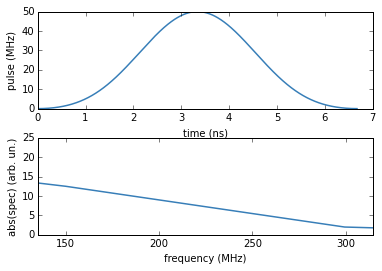

In [42]:
pulse.pulse().show()

In [43]:
U_guess = propagate(rf, 'pulse_guess.json', rwa=True, force=True)
print("Concurrence: %f" % U_guess.closest_unitary().concurrence())
print("Loss: %f" % U_guess.pop_loss())

Concurrence: 0.049977
Loss: 0.004048


In [44]:
U_guess.F_avg(H_left)

0.2052330124614023

In [52]:
U_guess.F_sm(H_left)

0.0075533107411511436

In [45]:
1 - U_guess.F_avg(H_left)

0.79476698753859765

In [51]:
proc = system("./run_oct.py --continue --rwa --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [ ]:
proc.join()

In [53]:
U = propagate(rf, 'pulse.dat', rwa=True, force=True, keep=True);
! tail {rf}/oct_iters.dat | cut -b 1-80

  402  6.170019224608E-01  7.145936562145E-05  0.000000000000E+00  6.17073381826
  403  6.168600656672E-01  7.050369524544E-05  0.000000000000E+00  6.16930569362
  404  6.167201390014E-01  6.956285278423E-05  0.000000000000E+00  6.16789701854
  405  6.165821111341E-01  6.863688735933E-05  0.000000000000E+00  6.16650748021
  406  6.164459506638E-01  6.772581782673E-05  0.000000000000E+00  6.16513676481
  407  6.163116261817E-01  6.682963518875E-05  0.000000000000E+00  6.16378455816
  408  6.161791063309E-01  6.594830498860E-05  0.000000000000E+00  6.16245054635
  409  6.160483598605E-01  6.508176966108E-05  0.000000000000E+00  6.16113441630
  410  6.159193556747E-01  6.422995081650E-05  0.000000000000E+00  6.15983585625
  411  6.157920628763E-01  6.339275143860E-05  0.000000000000E+00  6.15855455627


In [54]:
U.F_avg(H_left)

0.41484950911262047

In [58]:
U.F_sm(H_left)

0.38420793723707608

In [55]:
U.pop_loss()

0.46258420338520179

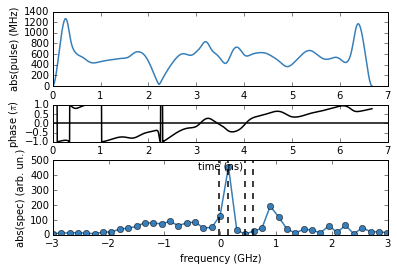

In [59]:
QDYN.pulse.Pulse(join(rf, 'pulse.dat')).show(
    mark_freqs=mark_freqs(rf, transition_table),
    mark_freq_points='o', wmin=-3, wmax=3)

/data/goerz/jobs/ConstrainedTransmon/venv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


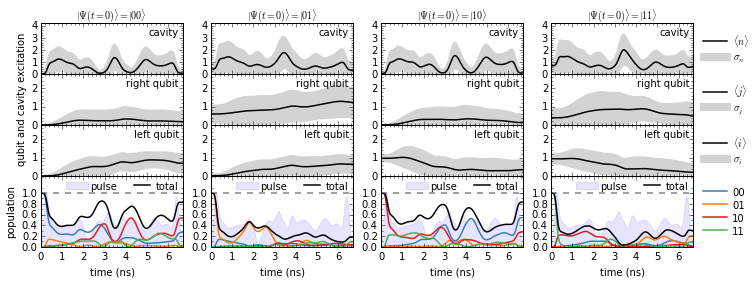

In [60]:
QDYNTransmonLib.popdyn.PopPlot(rf).show()

The strong pulses populate high levels, and induce too much dissipation (loss of norm)

In [61]:
! cat {rf}/prop.log | grep norm | grep -v red

norm(psi1) =    9.7755777816122724E-01
norm(psi2) =    8.8616613459610338E-01
norm(psi3) =    9.6480403801853176E-01
norm(psi4) =    8.3874031550526207E-01


#### $H_L$ at $T = 80 T_\pi$

In [161]:
rf = join(root, '40cycle_H_left'); mkdir(rf)
wd = 0.5*(w1+w2)

In [63]:
rf

'./runs_zeta_detailed/w2_6390MHz_wc_6350MHz/40cycle_H_left'

In [64]:
T = 80*T_entangling
nt = int(max(2000, 100 * w_max * T))
write_target_gate_dat(rf, 'H_left')
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="target_gate.dat", J_T='SM', prop_guess='F')

In [65]:
T

267.0726170445743

In [66]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 0.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
systematic_variation(rf, pulse, vary=OrderedDict([
            ('E0', [0.0, 20, 50, 100]), 
            ('w_L', [w1, w2, 0.5*(w1+w2),  
                     w1_dressed0, w1_dressed1, 0.5*(w1_dressed0+w1_dressed1),
                     w2_dressed0, w2_dressed1, 0.5*(w2_dressed0+w2_dressed1)])]),
            fig_of_merit=F_avg_H_left, n_procs=40)

,E0,w_L,fig_of_merit
28,100,6.390000,0.065370
34,100,6.297198,0.160431
35,100,6.372084,0.167946
33,100,6.446970,0.168966
19,50,6.390000,0.198423
32,100,5.911186,0.205069
24,50,6.446970,0.213586
15,20,6.446970,0.226901
30,100,5.986072,0.235576
21,50,5.986072,0.241762


In [67]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 50.0, 'T': T, 'w_L': 6.000000, 'w_d': 6.000000},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))

In [68]:
U_guess = propagate(rf, 'pulse_guess.json', rwa=True, force=True)
print("Concurrence: %f" % U_guess.closest_unitary().concurrence())
print("Loss: %f" % U_guess.pop_loss())

Concurrence: 0.147956
Loss: 0.050370


In [69]:
proc = system("./run_oct.py --continue --rwa --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [71]:
proc.join()

In [88]:
U = propagate(rf, 'pulse.dat', rwa=True, force=True, keep=True);
! tail {rf}/oct_iters.dat | cut -b 1-80

 3201  3.449381928524E-02  1.002865768040E-07  0.000000000000E+00  3.44939195718
 3202  3.449361377392E-02  1.002528892464E-07  0.000000000000E+00  3.44937140268
 3203  3.449340834527E-02  1.002192018522E-07  0.000000000000E+00  3.44935085644
 3204  3.449320299931E-02  1.001855144728E-07  0.000000000000E+00  3.44933031848
 3205  3.449299773600E-02  1.001518269613E-07  0.000000000000E+00  3.44930978878
 3206  3.449279255533E-02  1.001181391726E-07  0.000000000000E+00  3.44928926734
 3207  3.449258745726E-02  1.000844509618E-07  0.000000000000E+00  3.44926875417
 3208  3.449238244176E-02  1.000507621865E-07  0.000000000000E+00  3.44924824925
 3209  3.449217750886E-02  1.000170727015E-07  0.000000000000E+00  3.44922775259
 3210  3.449197265844E-02  9.998338236700E-08  0.000000000000E+00  3.44920726418


In [89]:
U.pop_loss()

0.034356620044204256

In [90]:
U.F_avg(H_left)

0.96553509789441994

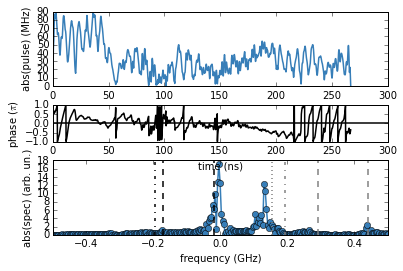

In [162]:
QDYN.pulse.Pulse(join(rf, 'pulse.dat')).show(
    mark_freqs=mark_freqs(rf, transition_table),
    mark_freq_points='o', wmin=-0.5, wmax=0.5)

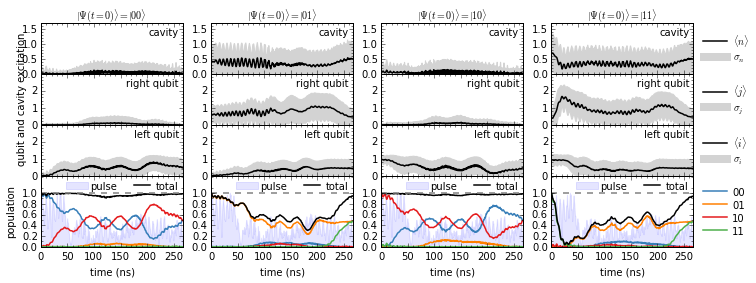

In [92]:
QDYNTransmonLib.popdyn.PopPlot(rf).show()

Gate is implemented successfully, but is limited by the decoherence, due to the long gate duration

In [93]:
! cat {rf}/prop.log | grep norm | grep -v red

norm(psi1) =    9.9343323452592569E-01
norm(psi2) =    9.7386265584894005E-01
norm(psi3) =    9.9252266029133251E-01
norm(psi4) =    9.7071683407562659E-01


In [94]:
wd = get_w_d_from_config(join(rf, 'config'))
pulse_ff = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 0.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse_ff.write(join(rf, 'pulse_ff.json'))
U_ff = propagate(rf, 'pulse_ff.json', rwa=True, force=True, keep=None);

In [95]:
U_ff.pop_loss()

0.036605228305860216

In [97]:
U.pop_loss()

0.034356620044204256

#### $H_L$ at $T = 50$ ns

In [187]:
rf = join(root, '50ns_H_left'); mkdir(rf)
wd = 0.5*(w1+w2)

In [188]:
rf

'./runs_zeta_detailed/w2_6390MHz_wc_6350MHz/50ns_H_left'

In [100]:
T = 50
nt = int(max(2000, 100 * w_max * T))
write_target_gate_dat(rf, 'H_left')
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="target_gate.dat", J_T='SM', prop_guess='F')

In [101]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 0.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
systematic_variation(rf, pulse, vary=OrderedDict([
            ('E0', [0.0, 20, 50, 100]), 
            ('w_L', [w1, w2, 0.5*(w1+w2),  
                     w1_dressed0, w1_dressed1, 0.5*(w1_dressed0+w1_dressed1),
                     w2_dressed0, w2_dressed1, 0.5*(w2_dressed0+w2_dressed1)])]),
            fig_of_merit=F_avg_H_left, n_procs=40)

,E0,w_L,fig_of_merit
28,100,6.390000,0.046420
35,100,6.372084,0.096070
33,100,6.446970,0.132721
34,100,6.297198,0.143346
30,100,5.986072,0.155863
16,20,6.297198,0.169874
9,20,6.000000,0.210756
21,50,5.986072,0.213161
18,50,6.000000,0.215795
15,20,6.446970,0.215932


In [104]:
pulse_ff = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 0.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse_ff.write(join(rf, 'pulse_ff.json'))
U_ff = propagate(rf, 'pulse_ff.json', rwa=True, force=True, keep=None);

In [106]:
U_ff.pop_loss()

0.0070283723599268155

In [102]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 100.0, 'T': T, 'w_L': 6.000000, 'w_d': 6.000000},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))

In [103]:
U_guess = propagate(rf, 'pulse_guess.json', rwa=True, force=True)
print("Concurrence: %f" % U_guess.closest_unitary().concurrence())
print("Loss: %f" % U_guess.pop_loss())

Concurrence: 0.998375
Loss: 0.126678


In [108]:
proc2 = system("./run_oct.py --continue --rwa --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [110]:
proc2.join();

In [153]:
U = propagate(rf, 'pulse.dat', rwa=True, force=True, keep=True);
! tail {rf}/oct_iters.dat | cut -b 1-80

 5157  2.364653950332E-02  1.001603749399E-07  0.000000000000E+00  2.36466396636
 5158  2.364633631128E-02  1.001421546049E-07  0.000000000000E+00  2.36464364534
 5159  2.364613315754E-02  1.001239471188E-07  0.000000000000E+00  2.36462332814
 5160  2.364593004204E-02  1.001057524673E-07  0.000000000000E+00  2.36460301477
 5161  2.364572696478E-02  1.000875706356E-07  0.000000000000E+00  2.36458270523
 5162  2.364552392574E-02  1.000694016094E-07  0.000000000000E+00  2.36456239951
 5163  2.364532092485E-02  1.000512453746E-07  0.000000000000E+00  2.36454209760
 5164  2.364511796211E-02  1.000331019161E-07  0.000000000000E+00  2.36452179952
 5165  2.364491503750E-02  1.000149712200E-07  0.000000000000E+00  2.36450150524
 5166  2.364471215098E-02  9.999685327125E-08  0.000000000000E+00  2.36448121478


In [154]:
U.concurrence()

0.051613529943665158

In [155]:
1-U.F_avg(H_left)

0.023490262321964828

In [156]:
U.pop_loss()

0.022872462537839255

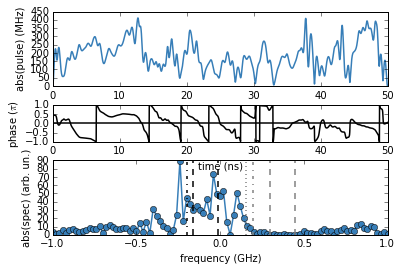

In [135]:
QDYN.pulse.Pulse(join(rf, 'pulse.dat')).show(
    mark_freqs=mark_freqs(rf, transition_table),
    mark_freq_points='o', wmin=-1, wmax=1)

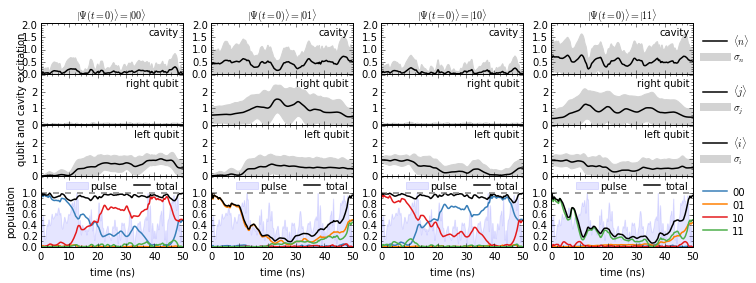

In [126]:
QDYNTransmonLib.popdyn.PopPlot(rf).show()

We can compare the dynamics with a propagation that has no dissipation at all

In [149]:
! rm -rf {rf}_nodiss && cp -r {rf} {rf}_nodiss

In [150]:
U_nodiss = propagate(rf+'_nodiss', 'pulse.dat', rwa=True, force=True, keep=all, dissipation=False);

In [151]:
U_nodiss.pop_loss()

0.012503679236879117

In [157]:
U.pop_loss()

0.022872462537839255

In [158]:
U.F_avg(H_left)

0.97650973767803517

In [160]:
U_nodiss.F_avg(H_left)

0.98653951764190639

What is the global phase of the achieve gate relative to the target gate?

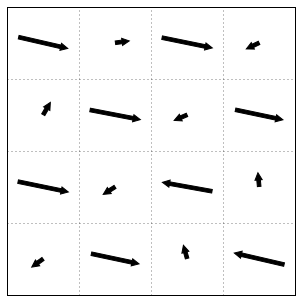

In [167]:
U.arrow_plot()

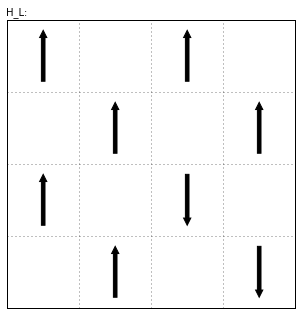

In [168]:
H_left.arrow_plot()

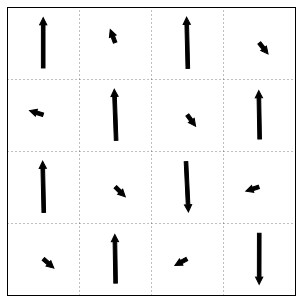

In [171]:
(np.exp(-1j*np.angle(U[0,0])) * U).arrow_plot()

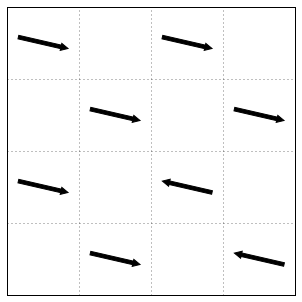

In [172]:
(np.exp(1j*np.angle(U[0,0])) * H_left).arrow_plot()

Try to continue optimization with RE-functional

In [204]:
! mkdir -p {rf}_RE
! cp {rf}/config.oct {rf}_RE/config
QDYN.pulse.Pulse(join(rf, 'pulse.dat')).write(join(rf+'_RE', 'pulse.guess'))
phase_factor = np.exp(1j*np.angle(U[0,0]))
writetotxt(join(rf+'_RE', 'target_gate.dat'),
           phase_factor*GATE_RE['H_left'],
           phase_factor*GATE_IM['H_left'])

In [205]:
proc_re = system("./run_oct.py --continue --rwa --J_T_re {rf}_RE".format(rf=rf))

In [207]:
proc_re.join()

In [208]:
! tail {rf}_RE/oct_iters.dat | cut -b 1-80

# Sat Mar 19 18:44:34 -0700 2016
# lambda_a =    1.000000E-04; lambda_intens =    0.000000E+00; lambda_b =    0.0
# it.                 J_T             g_a_int             g_b_int               
    0  1.193269888902E-02  0.000000000000E+00  0.000000000000E+00  1.19326988890
    8  1.193223145761E-02  0.000000000000E+00  0.000000000000E+00  1.19322314576
    9  1.192601455939E-02  0.000000000000E+00  0.000000000000E+00  1.19260145593
   10  1.192217341182E-02  0.000000000000E+00  0.000000000000E+00  1.19221734118
   11  1.191546637872E-02  0.000000000000E+00  0.000000000000E+00  1.19154663787


There is no significant improvement when continuing the optimization using the RE functional, either with Krovot or with LBFGS!

#### $H_L$ at $T = 4 T_\pi$ (two-tone)

We attempt to use a guess pulse that drives as precisely as possible exactly at both of the dressed left qubit frequencies.

In [209]:
rf = join(root, '2cycle_freq_H_left'); mkdir(rf)
wd = 0.5*(w1_dressed0 + w1_dressed1)

In [210]:
rf

'./runs_zeta_detailed/w2_6390MHz_wc_6350MHz/2cycle_freq_H_left'

In [211]:
T = 4*T_entangling
nt = int(max(2000, 100 * w_max * T))
write_target_gate_dat(rf, 'H_left')
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="target_gate.dat", J_T='SM', prop_guess='F')

In [212]:
pulse = AnalyticalPulse('2freq_rwa_box', T, nt,
            parameters={'E0': 100.0, 'T': T, 
                        'freq_1': w1_dressed0, 'freq_2': w1_dressed1,
                        'a_1': 1.0, 'a_2': 1.0, 'phi':0, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))

In [213]:
num_pulse = pulse.pulse()

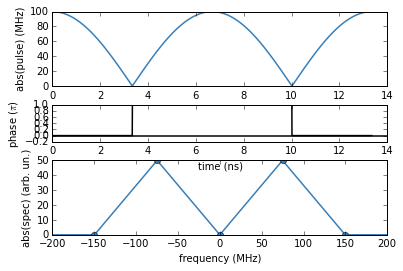

In [215]:
num_pulse.show(wmin=-200, wmax=200, mark_freq_points='o')

In [217]:
U_guess = propagate(rf, 'pulse_guess.json', rwa=True, force=True)
print("Concurrence: %f" % U_guess.closest_unitary().concurrence())
print("Loss: %f" % U_guess.pop_loss())

Concurrence: 0.448443
Loss: 0.105406


In [218]:
U_guess.F_avg(H_left)

0.18112781754171117

In [219]:
proc = system("./run_oct.py --continue --rwa --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [220]:
proc.join()

In [221]:
pulse_opt_simplex = AnalyticalPulse.read(join(rf, 'pulse_opt.json'))

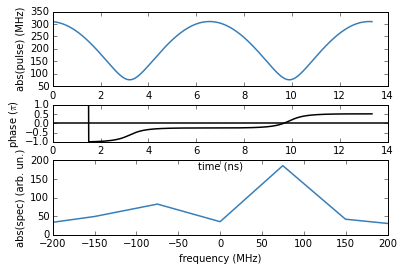

In [222]:
pulse_opt_simplex.pulse().show(wmin=-200, wmax=200)

In [223]:
U_opt_simplex = propagate(rf, 'pulse_opt.json', rwa=True, force=True)
print("Concurrence: %f" % U_guess.closest_unitary().concurrence())
print("Loss: %f" % U_guess.pop_loss())

Concurrence: 0.448443
Loss: 0.105406


In [224]:
U_opt_simplex.F_avg(H_left)

0.3087443214137004

In [225]:
U = propagate(rf, 'pulse.dat', rwa=True, force=True);
! tail {rf}/oct_iters.dat | cut -b 1-80

 9991  3.713618880565E-01  2.523678586675E-07  0.000000000000E+00  3.71362140424
 9992  3.713613849916E-01  2.524270813626E-07  0.000000000000E+00  3.71361637418
 9993  3.713608818084E-01  2.524864292360E-07  0.000000000000E+00  3.71361134294
 9994  3.713603785066E-01  2.525459023394E-07  0.000000000000E+00  3.71360631052
 9995  3.713598750860E-01  2.526055007247E-07  0.000000000000E+00  3.71360127691
 9996  3.713593715464E-01  2.526652244425E-07  0.000000000000E+00  3.71359624211
 9997  3.713588678874E-01  2.527250735440E-07  0.000000000000E+00  3.71359120612
 9998  3.713583641089E-01  2.527850480793E-07  0.000000000000E+00  3.71358616893
 9999  3.713578602105E-01  2.528451480982E-07  0.000000000000E+00  3.71358113055
10000  3.713573561921E-01  2.529053736500E-07  0.000000000000E+00  3.71357609097


In [226]:
U.F_avg(H_left)

0.3090821692851094